In [1]:
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
import matplotlib as mpl
from scipy.optimize import curve_fit
from scipy.stats import binned_statistic

In [2]:
import vice

from surp import subgiants
from surp import gce_math as gcem
from surp.gce_math import MH_to_Z, Z_to_MH, Z_SUN
import surp

import arya

/astro/dboyea/.local/lib/python3.11/site-packages/vice/__init__.py:141: UserWarning: Using un-released version of VICE
  warnings.warn("Using un-released version of VICE", UserWarning)


In [3]:
arya.style.set_size((4, 2*np.sqrt(2)))

In [4]:
surp.set_yields()

yields set to Magg et al. 2022 abundances
Yield settings
X        Z_solar    CC                             agb                            SN Ia                          

c        3.39e-03   3.69e-03 MH^2 + 1.96e-03 MH +  1.45 × cristallo11             0.00e+00                       
                    2.20e-03                                                                                     

n        1.04e-03   5.00e-04                       5.02e-04 M Z/Z0                0                              

o        7.33e-03   7.13e-03                       0                              0                              

mg       6.71e-04   6.52e-04                       0                              0                              

fe       1.37e-03   4.73e-04                       0                              7.70e-04                       





In [5]:
# all_abundances = pd.read_csv("data_analysis/all_data.csv")
# stars = pd.read_csv("../data/amarsi_19.tsv", delimiter="\t *", comment="#", skiprows=[62, 63], engine="python")
# stars["C_MG"] =  stars["[C/H]3N"] - stars["[O/H]3N"]
# stars["MG_H"] =  stars["[O/H]3N"]
# stars["C_MG_ERR"] = stars["e_[C/H]3N"] + stars["e_[O/H]3N"]

# df_stars = stars[["C_MG", "MG_H", "C_MG_ERR"]]

# all_abundances["C_MG"] = all_abundances["[c/o]"]
# all_abundances["MG_H"] = all_abundances["[o/h]"]
# all_abundances["C_MG_ERR"] = all_abundances["[c/o]_err"]

# stars_all = all_abundances[["C_MG", "MG_H", "C_MG_ERR"]][(~np.isnan(all_abundances.C_MG)) & (all_abundances.type == "star")]
# RL_all = all_abundances[["C_MG", "MG_H", "C_MG_ERR"]][(~np.isnan(all_abundances.C_MG)) & (all_abundances.type == "RL")]
# DLA_all = all_abundances[["C_MG", "MG_H", "C_MG_ERR"]][(~np.isnan(all_abundances.C_MG)) & (all_abundances.type == "DLA")]
# dwarf_all = all_abundances[["C_MG", "MG_H", "C_MG_ERR"]][(~np.isnan(all_abundances.C_MG)) & (all_abundances.type == "dwarf")]

In [6]:
# stars_x_obs = stars.MG_H
# stars_y_obs = stars.C_MG
# all_x_obs = all_abundances.MG_H
# all_y_obs = all_abundances.C_MG

In [7]:

filt = ~subgiants.high_alpha.values
df = subgiants[filt]

bins = np.quantile(df.MG_H, np.linspace(0, 1, 20))

counts = binned_statistic(df.MG_H, df.C_MG, bins=bins, statistic='count')[0]

ym = binned_statistic(df.MG_H, df.C_MG, bins=bins, statistic='median')[0]
yl = binned_statistic(df.MG_H, df.C_MG, bins=bins, statistic=lambda x: np.percentile(x, 16))[0]
yh = binned_statistic(df.MG_H, df.C_MG, bins=bins, statistic=lambda x: np.percentile(x, 84))[0]
ym_err = binned_statistic(df.MG_H, df.C_MG_ERR, bins=bins, statistic='mean')[0]


xm = binned_statistic(df.MG_H, df.MG_H, bins=bins, statistic='median')[0]
xl = binned_statistic(df.MG_H, df.MG_H, bins=bins, statistic=lambda x: np.percentile(x, 16))[0]
xh = binned_statistic(df.MG_H, df.MG_H, bins=bins, statistic=lambda x: np.percentile(x, 84))[0]
xm_err = binned_statistic(df.MG_H, df.MG_H_ERR, bins=bins, statistic='mean')[0]

In [8]:
yym = gcem.brak_to_abund_ratio(ym, "c", "mg")
yyl = gcem.brak_to_abund_ratio(yl - ym_err, "c", "mg")
yyh = gcem.brak_to_abund_ratio(yh + ym_err, "c", "mg")
yym_err = (yyh - yyl) / 2 / np.sqrt(counts)

x_err = (xh - xl)/ 2 / np.sqrt(counts)

In [9]:
obs = (xm, yym, x_err, yym_err)

In [10]:
def plot_obs():
    plt.errorbar(xm, yym, yerr=yym_err, xerr=x_err,  fmt=".", capsize=0)

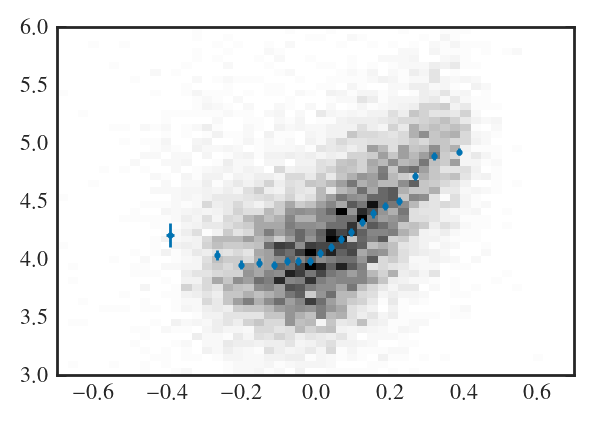

In [11]:
plt.hist2d(df.MG_H, gcem.brak_to_abund_ratio(df.C_MG, "c", "mg"), 50, range=([-0.7, 0.7], [3, 6]), cmap="Greys")
plot_obs()


In [12]:
params = surp.YieldParams.from_file("../models/fruity/f_0/yield_params.toml")
surp.set_yields(params)
y_c_lin = vice.yields.ccsne.settings["c"]

surp.set_yields(surp.YieldParams.from_file("../models/fiducial/yield_params.toml"))
y_c_quad = vice.yields.ccsne.settings["c"]

yields set to Magg et al. 2022 abundances
Yield settings
X        Z_solar    CC                             agb                            SN Ia                          

c        3.39e-03   3.69e-03 MH^2 + 1.96e-03 MH +  0.00 × cristallo11             0.00e+00                       
                    2.75e-03                                                                                     

n        1.04e-03   5.00e-04                       5.02e-04 M Z/Z0                0                              

o        7.33e-03   7.13e-03                       0                              0                              

mg       6.71e-04   6.52e-04                       0                              0                              

fe       1.37e-03   4.73e-04                       0                              7.70e-04                       



yields set to Magg et al. 2022 abundances
Yield settings
X        Z_solar    CC                             agb                          

In [13]:
params

YieldParams(yield_scale=1.0, mlr='larson1974', y_c_cc='Quadratic', y0_c_cc=0.002753396, zeta_c_cc=0.0019627619263157896, kwargs_c_cc={'A': 0.0036930257999999994}, Y_c_agb='cristallo11', alpha_c_agb=0.0, kwargs_c_agb={'mass_factor': 1, 'no_negative': False, 'interp_kind': 'linear', 'low_z_flat': False}, y_c_ia=0.0, y0_n_cc=0.0005, zeta_n_cc=0.0, Y_n_agb='A', kwargs_n_agb={}, eta_n_agb=0.000502, y0_n_agb=0.0, y_fe_cc=0.000473, y_fe_ia=0.00077)

In [14]:
ymg = vice.yields.ccsne.settings["mg"]

In [15]:
alpha = params.alpha_c_agb

In [16]:
y_c_lin = np.vectorize(y_c_lin)
y_c_quad = np.vectorize(y_c_quad)
def y_c_agb(Z):
    return y_agb_0 + zeta_agb * gcem.Z_to_MH(Z)

NameError: name 'y_agb_0' is not defined

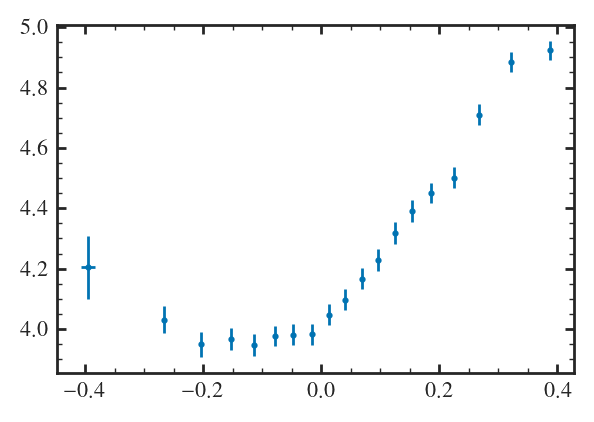

In [17]:
plot_obs()
x = np.linspace(-0.45, 0.45, 1000)
Z = gcem.MH_to_Z(x)
plt.plot(x, (y_c_lin(Z) + y_c_agb(Z)) / ymg, label="linear fit")
plt.plot(x,(y_c_quad(Z) + y_c_agb(Z))/ymg, ls="--", label="quadratic fit")

plt.legend()
plt.xlabel("[Mg/H]")
plt.ylabel(r"$y_{\rm C} / y_{\rm Mg}$")
plt.savefig("figures/equilibrium_yield.pdf")

# LS Fits

In [20]:
from scipy.optimize import curve_fit

In [21]:
def loglin(x, a, b):
    return a + b*x

In [22]:
popt, covt = curve_fit(loglin, xm, yym, sigma=yym_err)

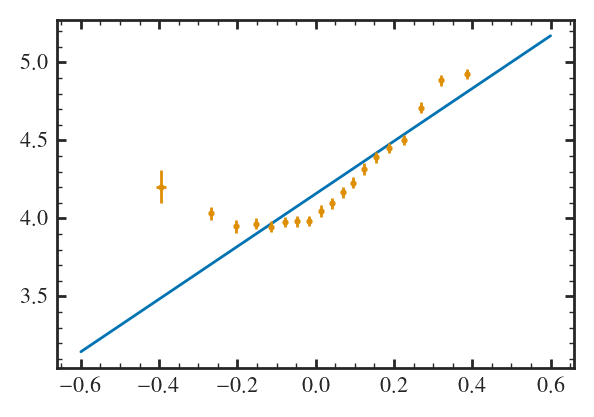

In [23]:
x_pred = np.linspace(-0.6, 0.6, 1000)
y_pred = loglin(x_pred, *popt)
plt.plot(x_pred, y_pred)
plot_obs()

In [24]:
def lin(x, a, b):
    Z = gcem.MH_to_Z(x)
    return a + b*(Z - Z_SUN)

In [25]:
popt, covt = curve_fit(lin, xm, yym, sigma=yym_err)

In [26]:
popt

array([ 4.10777999, 37.9574295 ])

In [ ]:
nu_

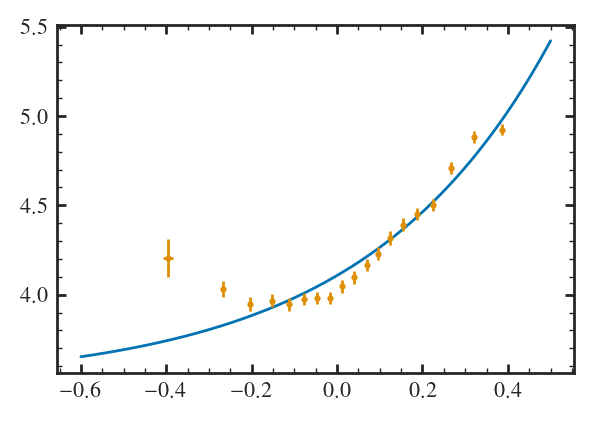

In [27]:
x_pred = np.linspace(-0.6, 0.5, 1000)
y_pred = lin(x_pred, *popt)
plt.plot(x_pred, y_pred)
plot_obs()

In [28]:
def logquad(x, a, b, c):
    return a + b*x + c*x**2

In [29]:
popt, covt = curve_fit(logquad, xm, yym, sigma=yym_err)

In [30]:
popt

array([4.06797597, 1.24113876, 3.29562947])

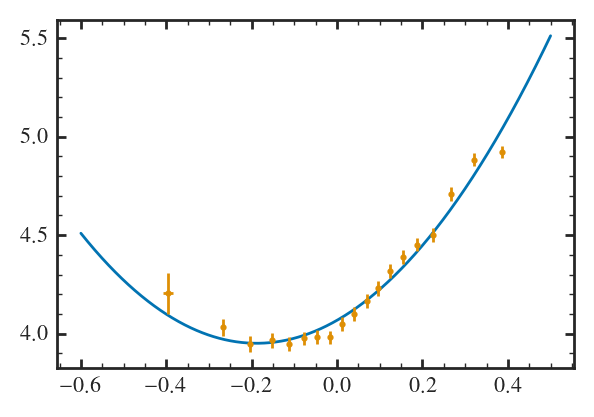

In [31]:
x_pred = np.linspace(-0.6, 0.5, 1000)
y_pred = logquad(x_pred, *popt)
plt.plot(x_pred, y_pred)
plot_obs()

In [32]:
def logexp(x, a, b, c):
    return a + b*np.exp(x*c)

In [33]:
popt, covt = curve_fit(logexp, xm, yym, sigma=yym_err)

In [34]:
popt, np.sqrt(np.diag(covt))

(array([3.71850025, 0.37888965, 3.21865718]),
 array([0.12492541, 0.12686918, 0.69129873]))

Text(0, 0.5, '$y_{\\rm C}/y_{\\rm Mg}$')

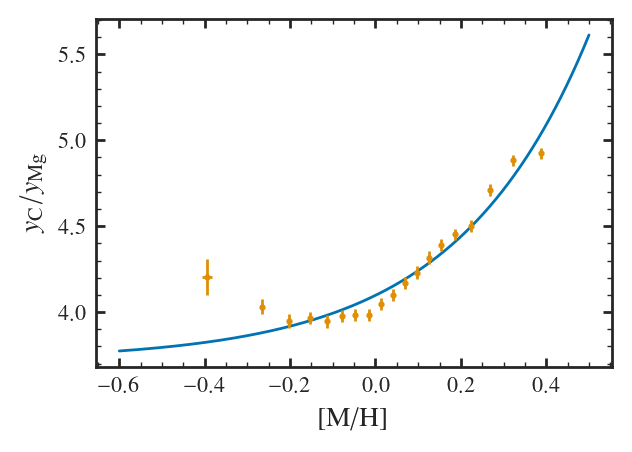

In [35]:
x_pred = np.linspace(-0.6, 0.5, 1000)
y_pred = logexp(x_pred, *popt)
plt.plot(x_pred, y_pred)
plot_obs()
plt.xlabel("[M/H]")
plt.ylabel(r"$y_{\rm C}/y_{\rm Mg}$")

In [36]:
def logloglin(x, a, b, c):
    return 10**(a + b*x + c*x**2)

[0.61022173 0.12688242 0.29306896]


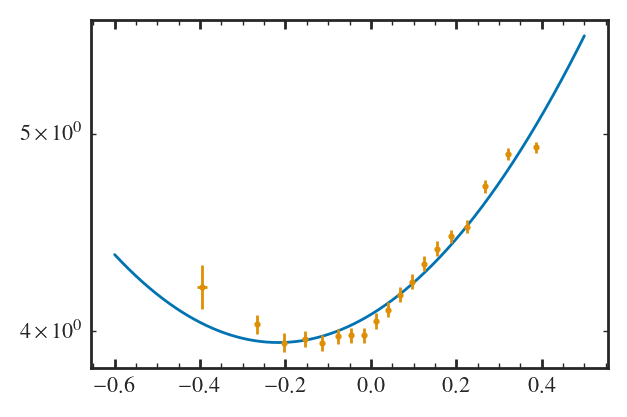

In [37]:
popt, covt = curve_fit(logloglin, xm, yym, sigma=yym_err)
print(popt)
x_pred = np.linspace(-0.6, 0.5, 1000)
y_pred = logloglin(x_pred, *popt)
plt.plot(x_pred, y_pred)
plot_obs()
plt.yscale("log")

In [38]:
def piecewise(x, a, b, a0):
    return np.maximum(a + b*x, a0)

In [39]:
y = surp.yield_models.BiLogLin_CC(y0=4, y1=4, zeta=2.5)

[3.99900653 2.50993995 3.97847379]


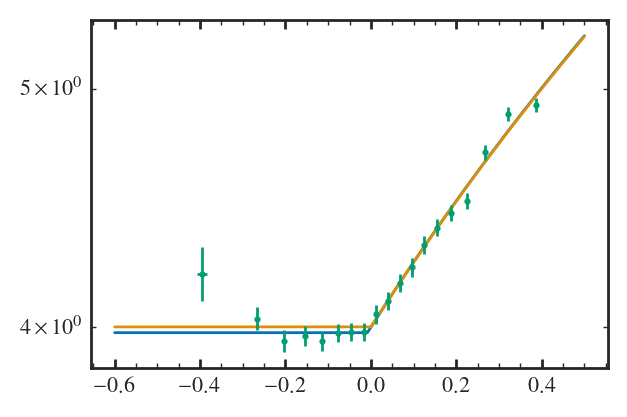

In [40]:
popt, covt = curve_fit(piecewise, xm, yym, sigma=yym_err, p0=(4.5, 0, 4.2))
print(popt)
x_pred = np.linspace(-0.6, 0.5, 1000)
y_pred = piecewise(x_pred, *popt)
plt.plot(x_pred, y_pred)
plt.plot(x_pred, [y(Z) for Z in gcem.MH_to_Z(x_pred)])
plot_obs()
plt.yscale("log")

In [41]:
2.5 * ymg

0.00163

# How do the stars work?

In [18]:
ymg = vice.yields.ccsne.settings["mg"]

In [19]:
def agb_model(m_h):
    return (3.23e-04 + -4.79e-04*m_h - 0*6.43e-05*m_h**2) / ymg

In [20]:
x_pred = np.linspace(-2, 0.6, 1000)
y_pred = logquad(x_pred, *popt)

NameError: name 'logquad' is not defined

In [21]:
#plt.scatter(stars_x_obs, gcem.brak_to_abund(stars_y_obs, "c", "mg"))
plt.plot(x_pred, y_pred)
plt.plot(x_pred, y_pred - agb_model(x_pred))
plt.plot(x_pred, agb_model(x_pred))

plt.xlim(-2.5, 0.6)

NameError: name 'y_pred' is not defined

# MCMC fits

In [20]:
N = 3_000

In [21]:
import mcmc_utils

In [22]:
def plot_res(model, samples):
    theta_m = np.median(samples, axis=0)
    y_pred = model(xm, theta_m)

    #plt.scatter(x_obs, y_obs - y_pred, s=2, c=w, ec="none", cmap="Greys", alpha=0.4)
    plt.scatter(xm, yym - y_pred, )
    plt.ylim(-0.3, 0.3)
    plt.xlim(-0.5)
    plt.axhline(0, ls="--")

In [23]:
model = mcmc_utils.Linear(beta0=[4, 0.5], beta1=[0, 1], log_sigma=[-15, 0.5])

100%|█████████████████████████████████████████████| 1000/1000 [00:11<00:00, 85.71it/s]


$\beta_0$ = 3.99e+00 + 4.84e-01 - 5.19e-01
$\beta_1$ = -6.66e-03 + 1.01e+00 - 9.47e-01
$\log(\sigma)$ = -1.50e+01 + 4.96e-01 - 5.66e-01


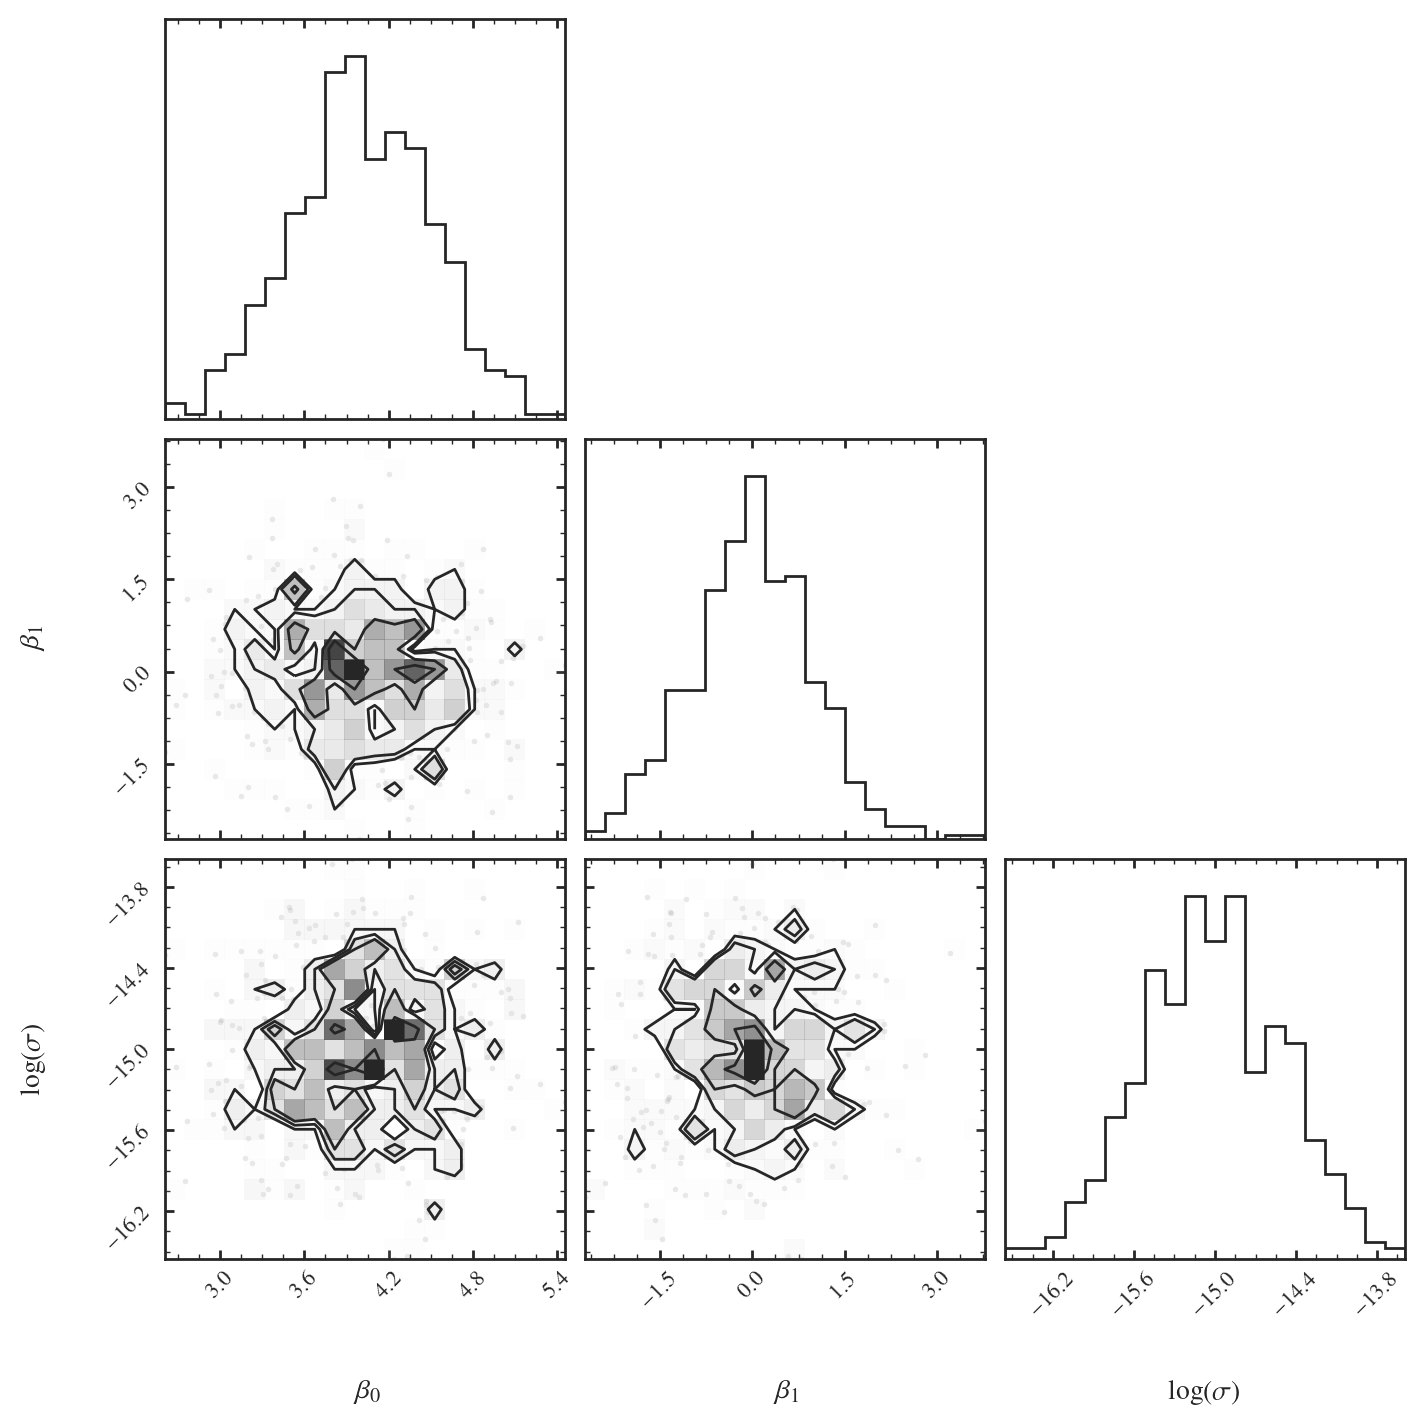

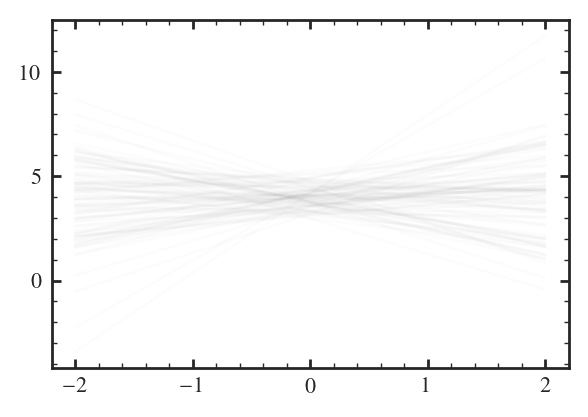

In [24]:
mcmc_utils.plot_prior(model, N=1_000)

100%|█████████████████████████████████████████████| 3000/3000 [01:46<00:00, 28.14it/s]


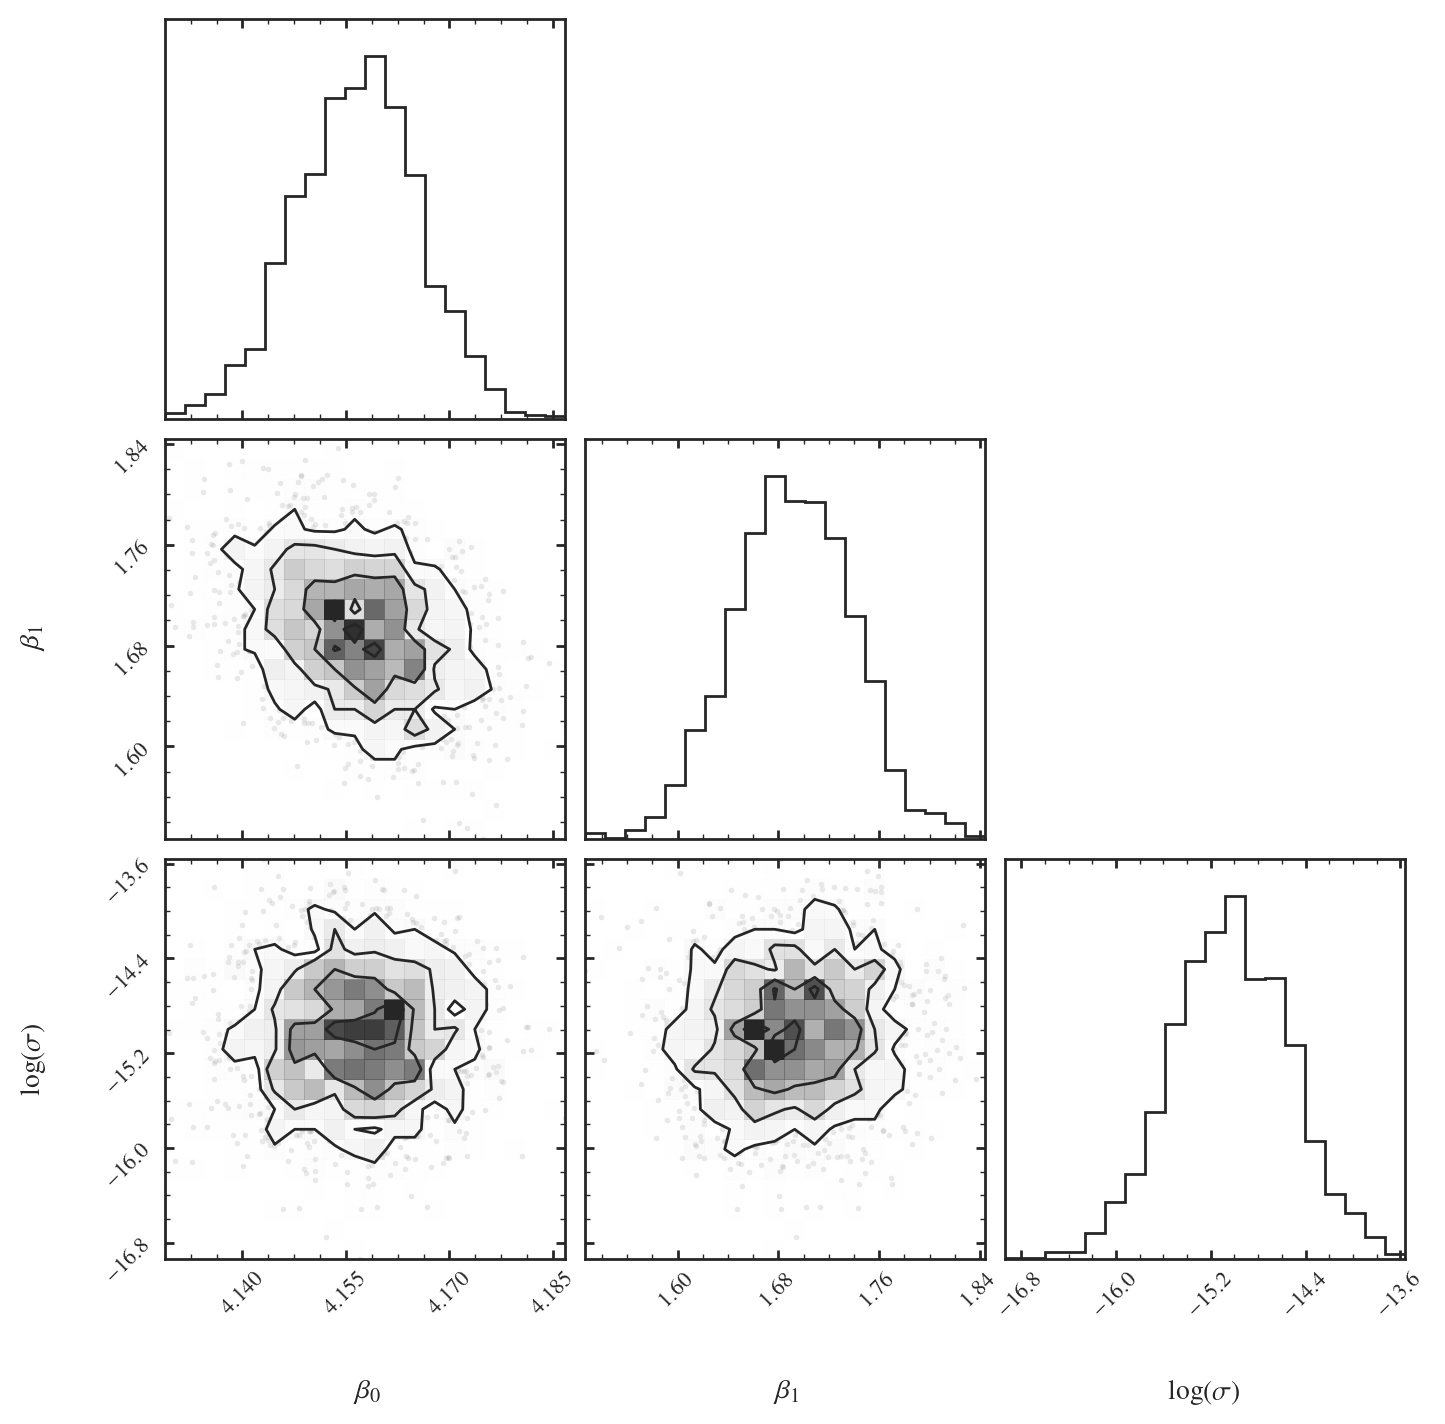

In [52]:
samples = mcmc_utils.run_mcmc(model, obs,N=N )

$\beta_0$ = 4.16e+00 + 9.21e-03 - 8.39e-03
$\beta_1$ = 1.69e+00 + 4.58e-02 - 4.76e-02
$\log(\sigma)$ = -1.50e+01 + 4.93e-01 - 4.99e-01


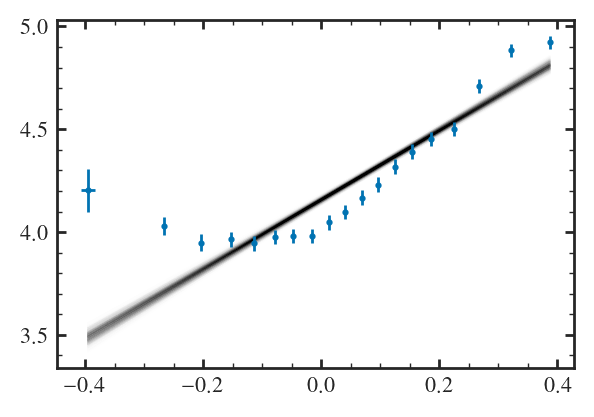

In [53]:
mcmc_utils.plot_posterior(model, obs, samples, N_lines=500)

# Exponential model

In [41]:
model  = mcmc_utils.Exponential(beta0=[4, 0.5], beta1=[0.0, 0.4], log_sigma=[-120, 1], alpha=[0, 4])

100%|█████████████████████████████████████████████| 1000/1000 [00:12<00:00, 78.44it/s]


$\beta_0$ = 3.96e+00 + 5.24e-01 - 5.59e-01
$\beta_1$ = 6.72e-04 + 4.28e-01 - 4.10e-01
$\log(\sigma)$ = -1.20e+02 + 9.23e-01 - 9.14e-01
$\alpha$ = 1.08e-01 + 4.31e+00 - 4.09e+00


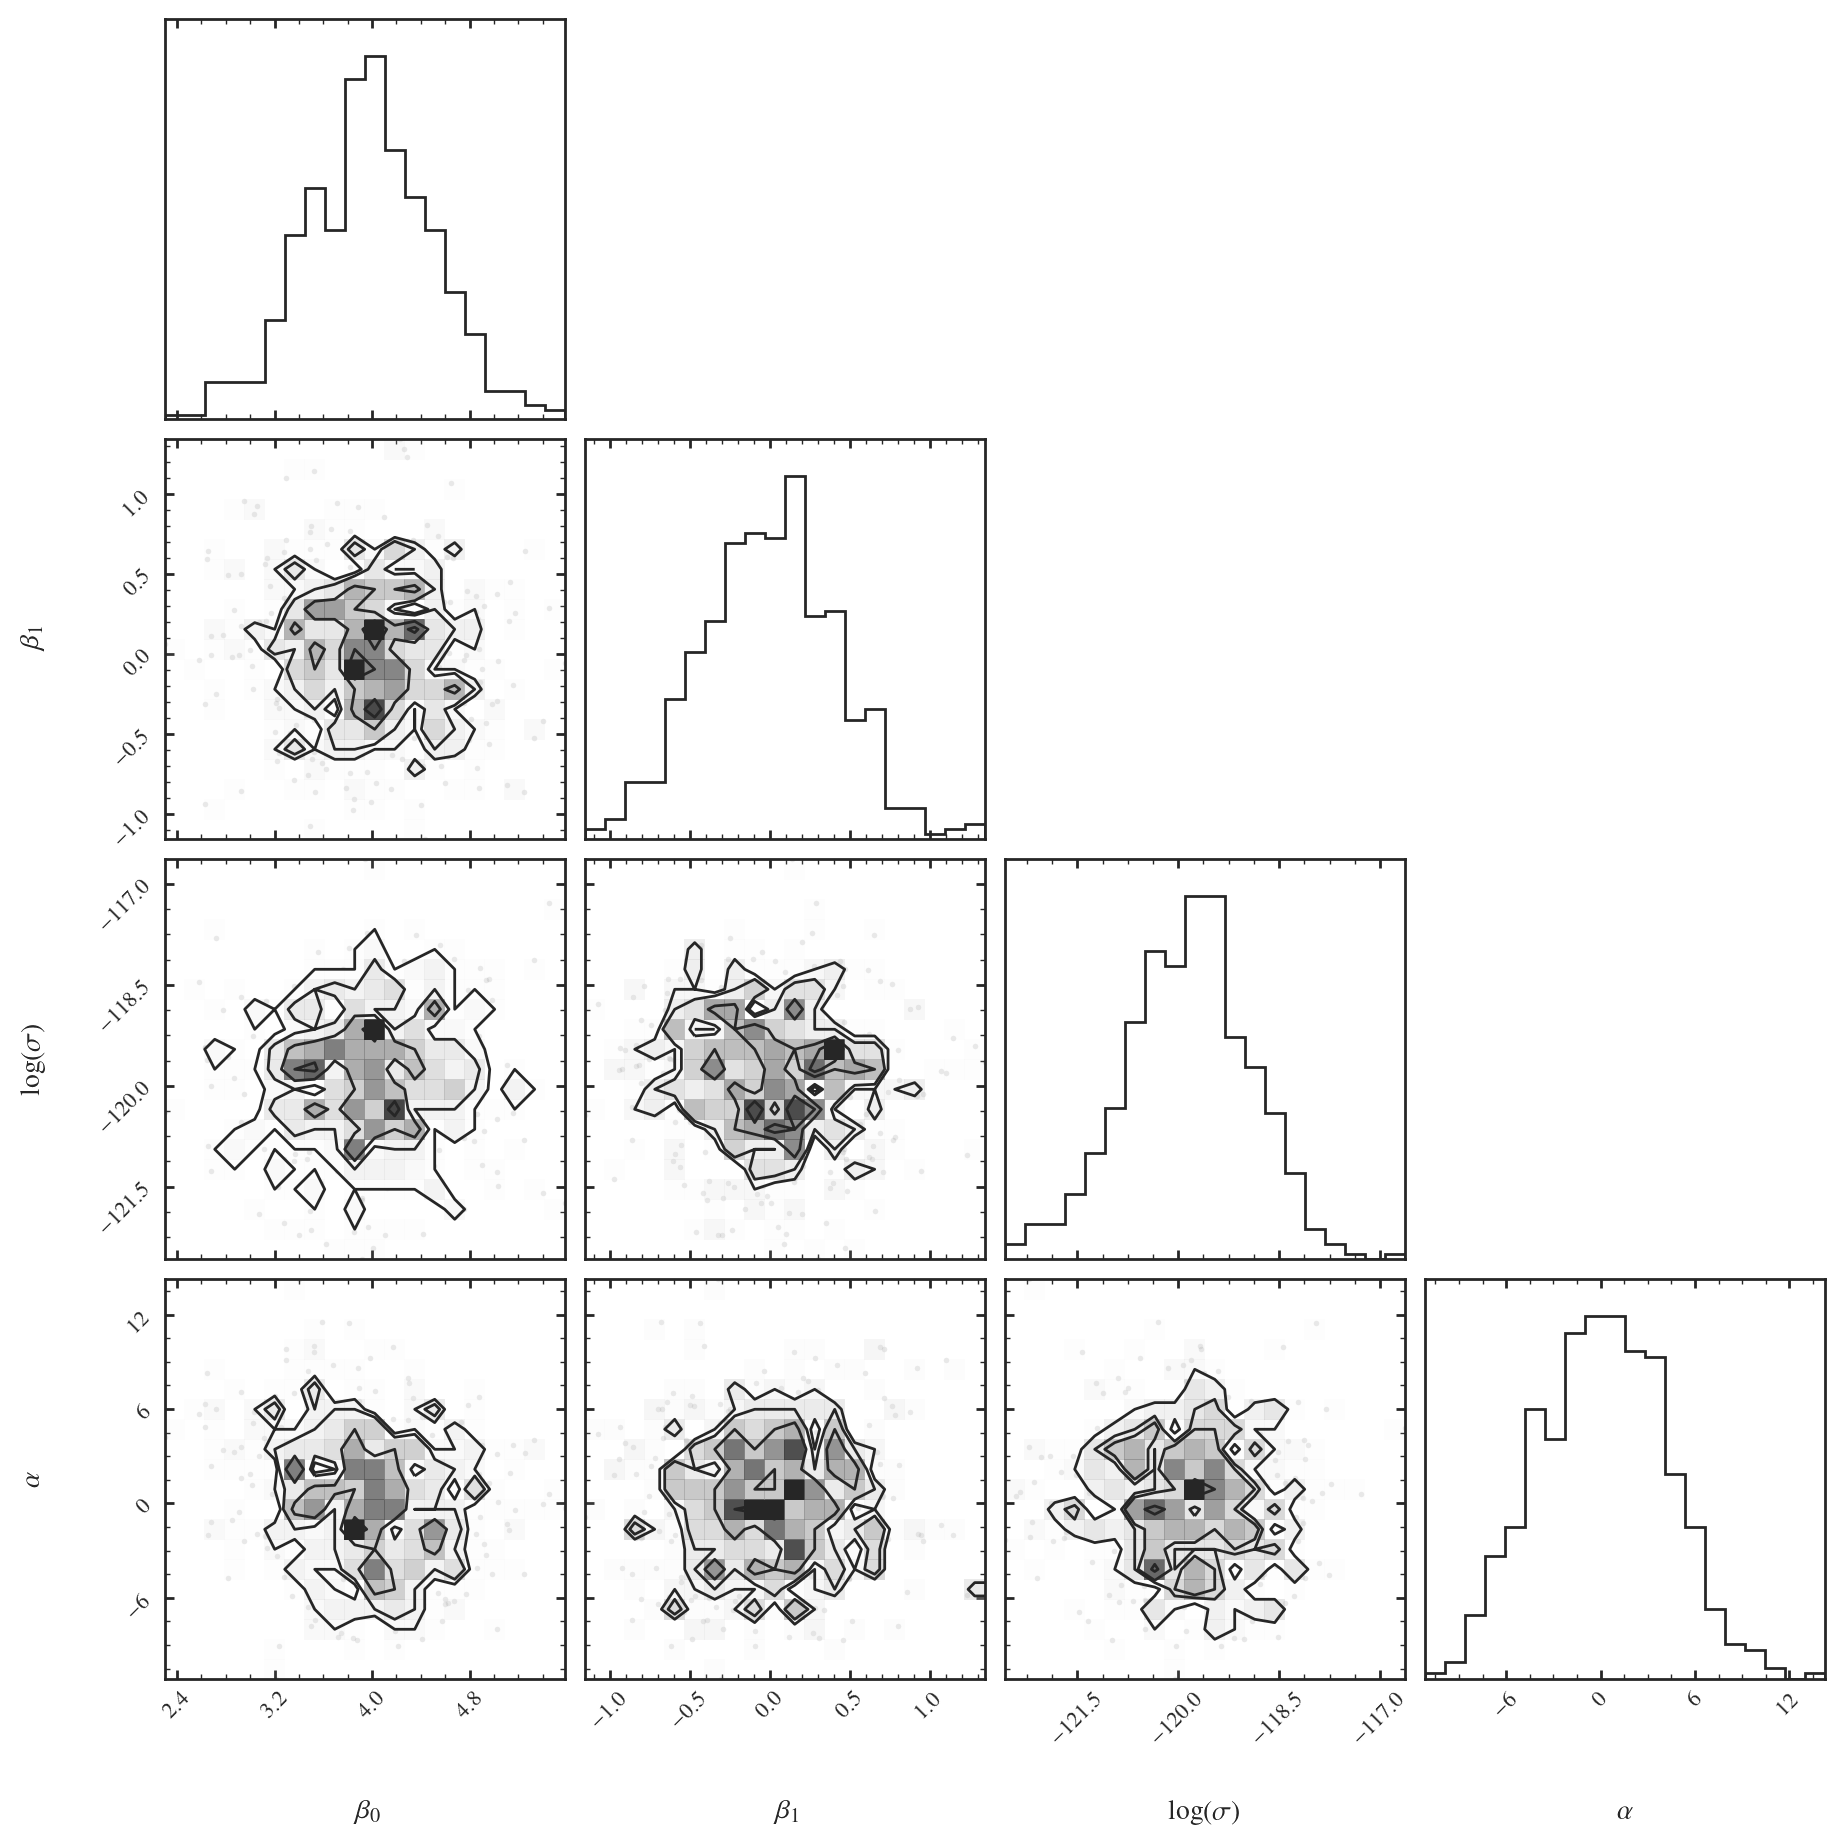

(3.0, 5.0)

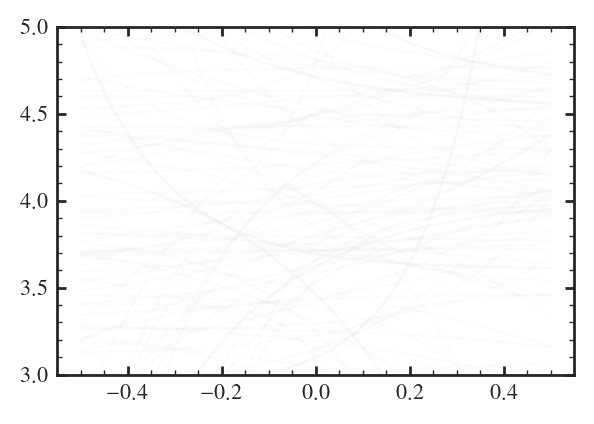

In [42]:
mcmc_utils.plot_prior(model, xlims=(-0.5, 0.5))
plt.ylim(3, 5)

100%|█████████████████████████████████████████████| 3000/3000 [00:43<00:00, 68.73it/s]


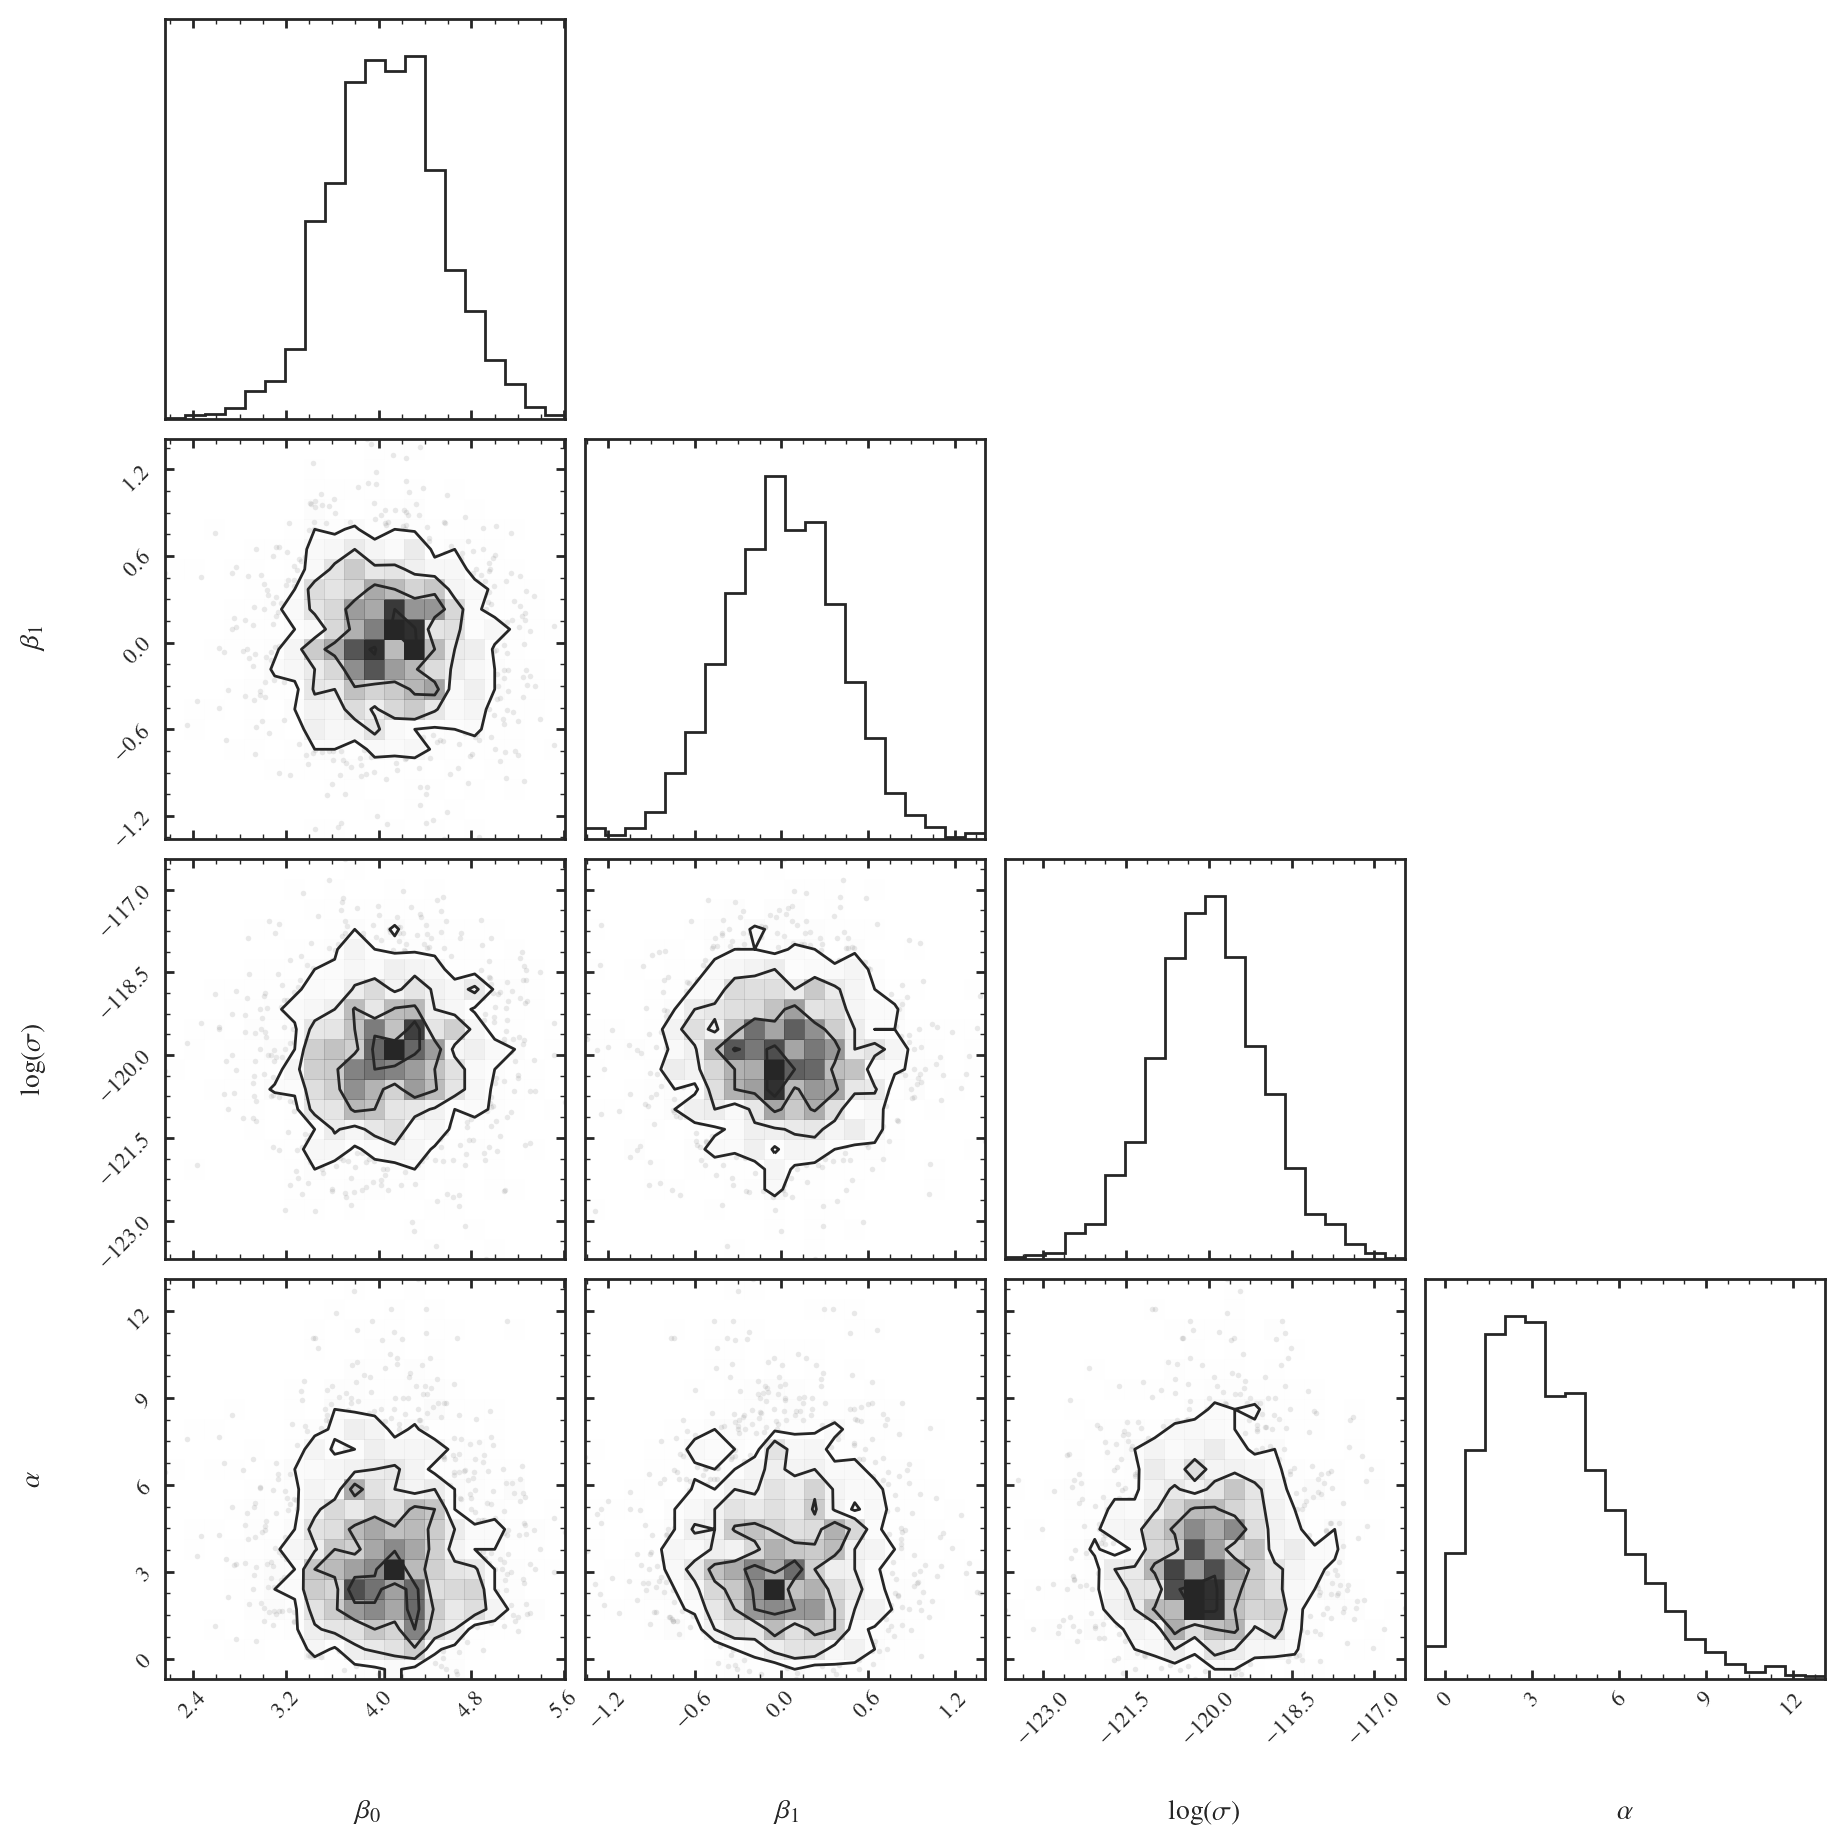

In [43]:
samples = mcmc_utils.run_mcmc(model, obs, N=N)

$\beta_0$ = 4.06e+00 + 4.86e-01 - 4.67e-01
$\beta_1$ = 6.36e-03 + 3.96e-01 - 3.98e-01
$\log(\sigma)$ = -1.20e+02 + 9.39e-01 - 9.91e-01
$\alpha$ = 3.32e+00 + 1.84e+00 - 2.69e+00


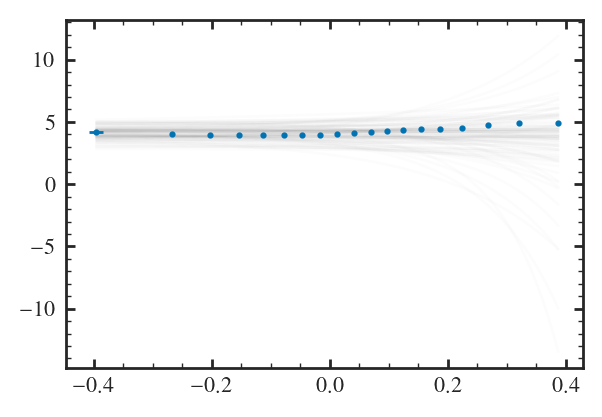

In [44]:
mcmc_utils.plot_posterior(model, obs, samples)

## Quadratic model

In [45]:
model  = mcmc_utils.Quadratic(beta0=[4, 0.5], beta1=[0, 1], log_sigma=[-15, 1])

100%|█████████████████████████████████████████████| 1000/1000 [00:13<00:00, 72.93it/s]


$\beta_0$ = 4.05e+00 + 4.66e-01 - 4.98e-01
$\beta_1$ = -6.71e-02 + 1.00e+00 - 1.09e+00
$\beta_2$ = 1.74e-02 + 9.52e-01 - 9.57e-01
$\log(\sigma)$ = -1.50e+01 + 1.08e+00 - 1.03e+00


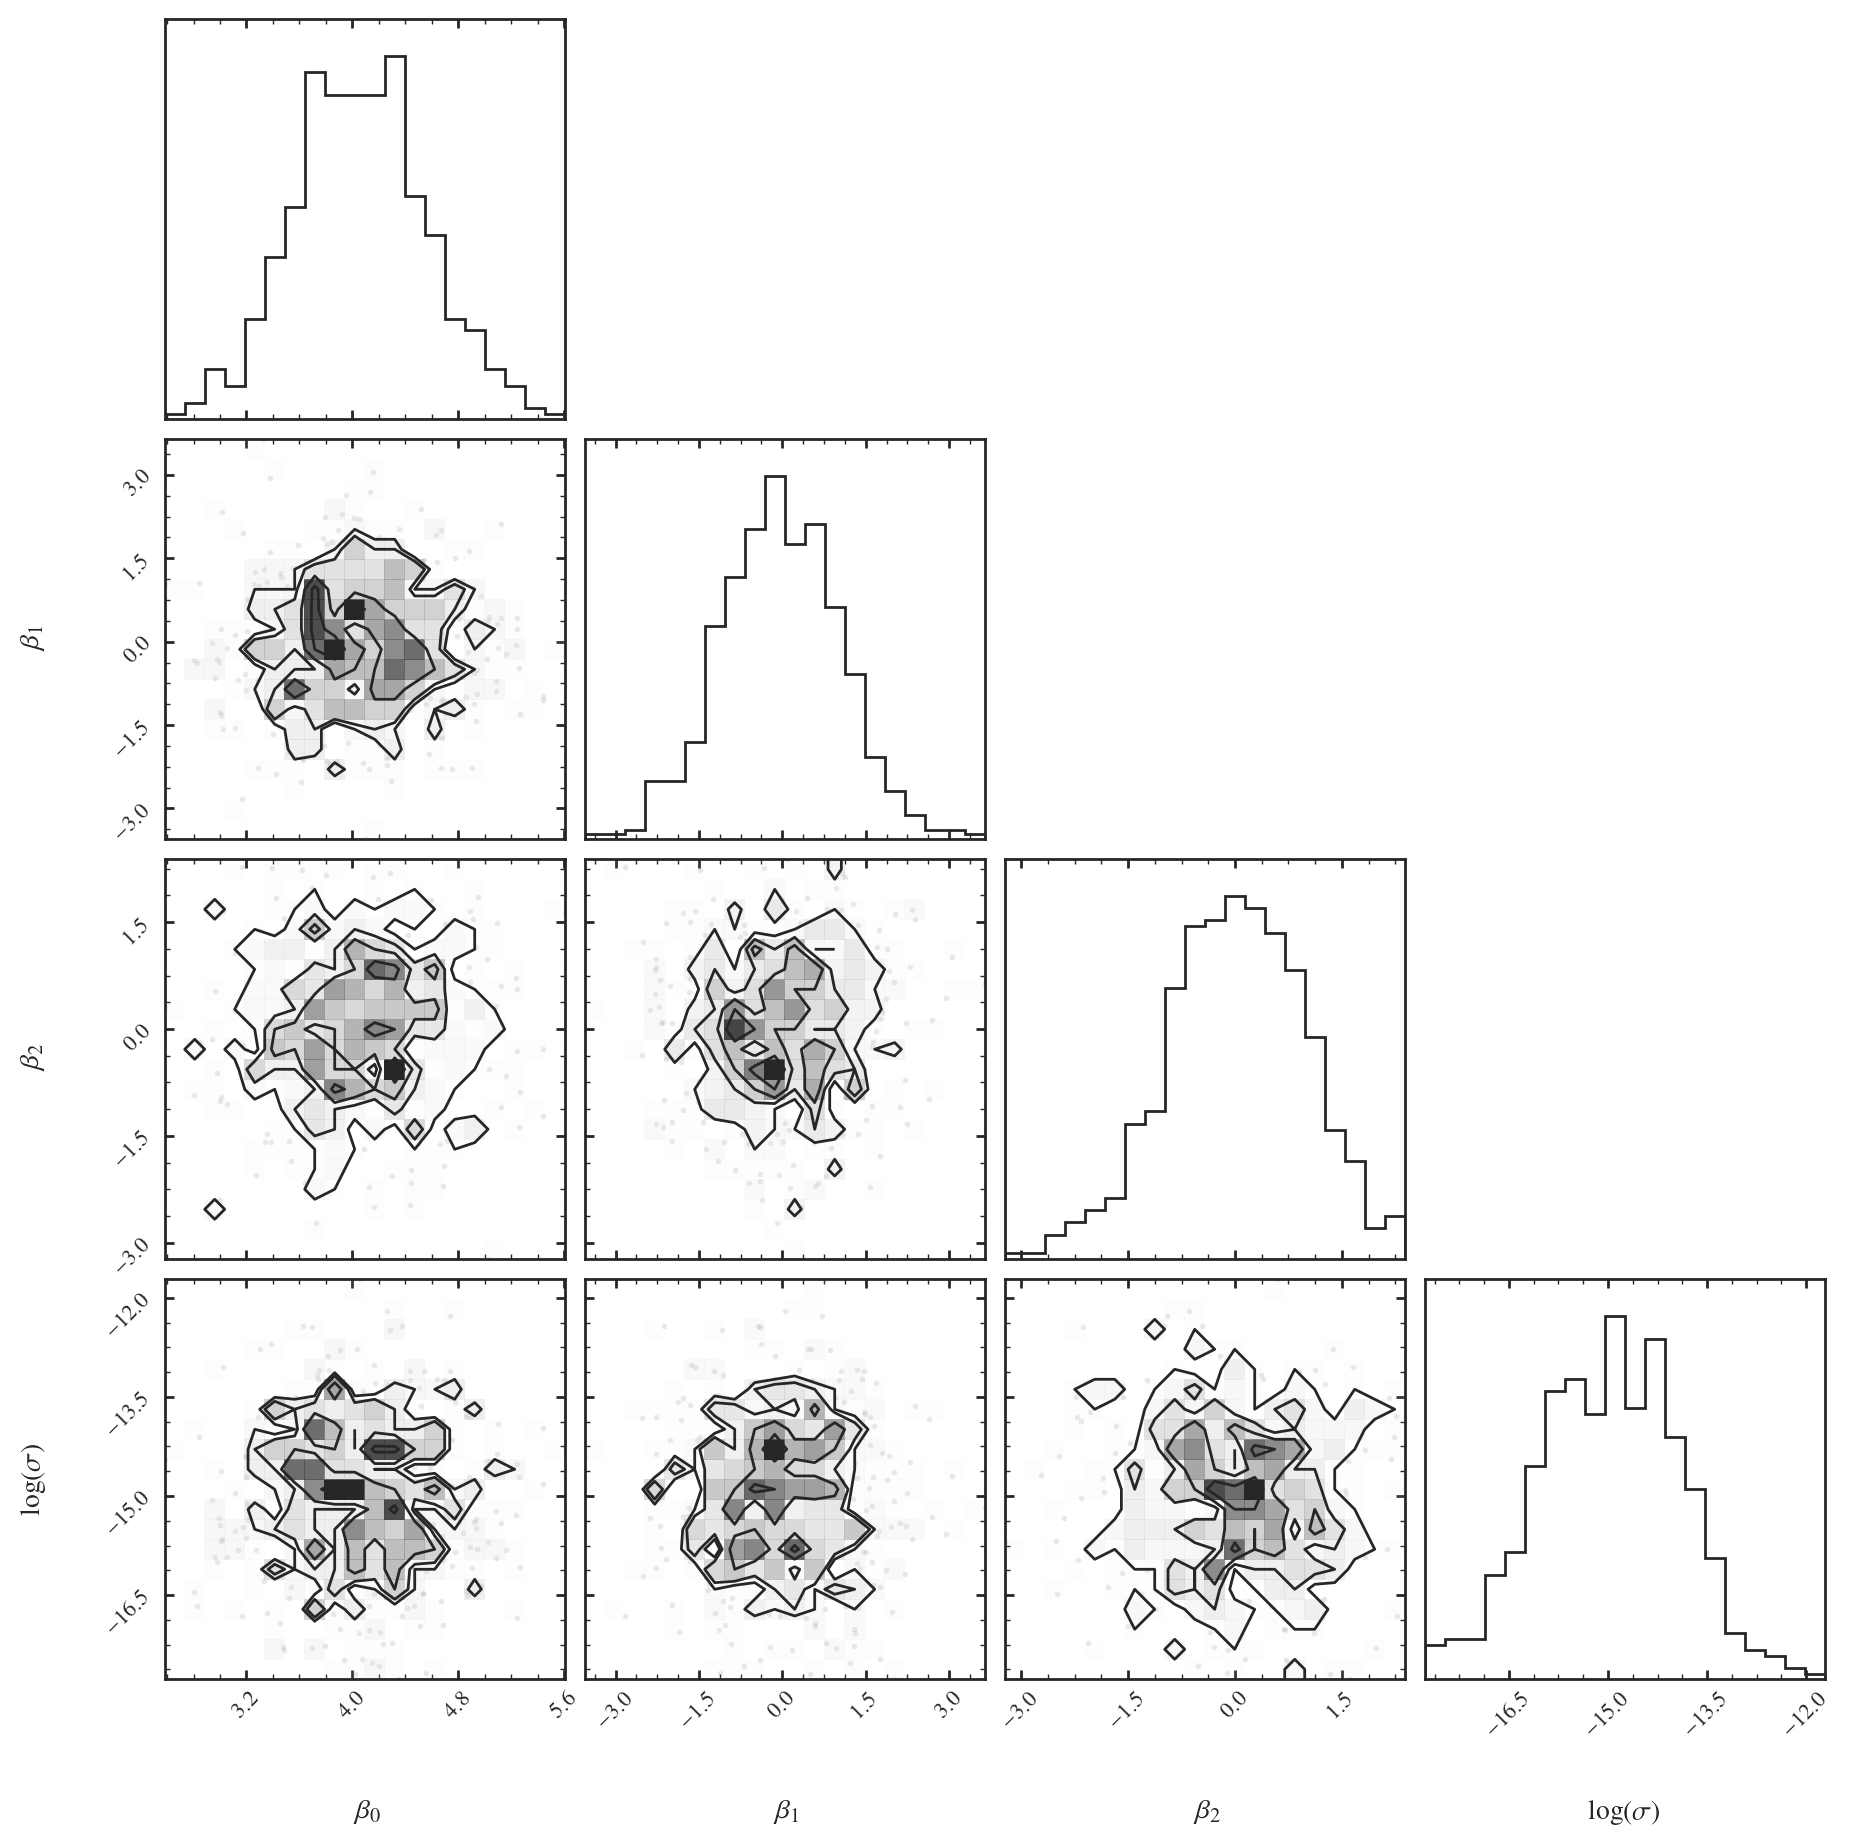

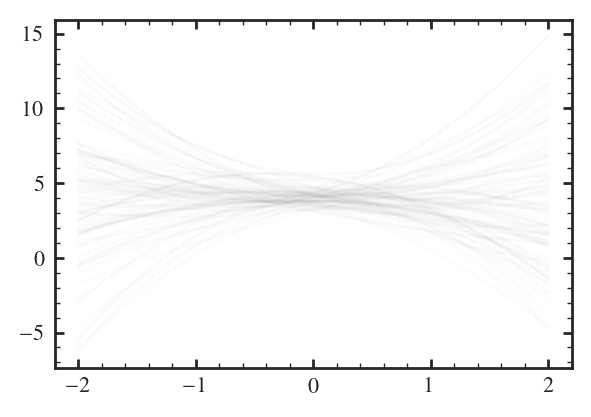

In [46]:
mcmc_utils.plot_prior(model)

100%|█████████████████████████████████████████████| 3000/3000 [00:43<00:00, 68.67it/s]


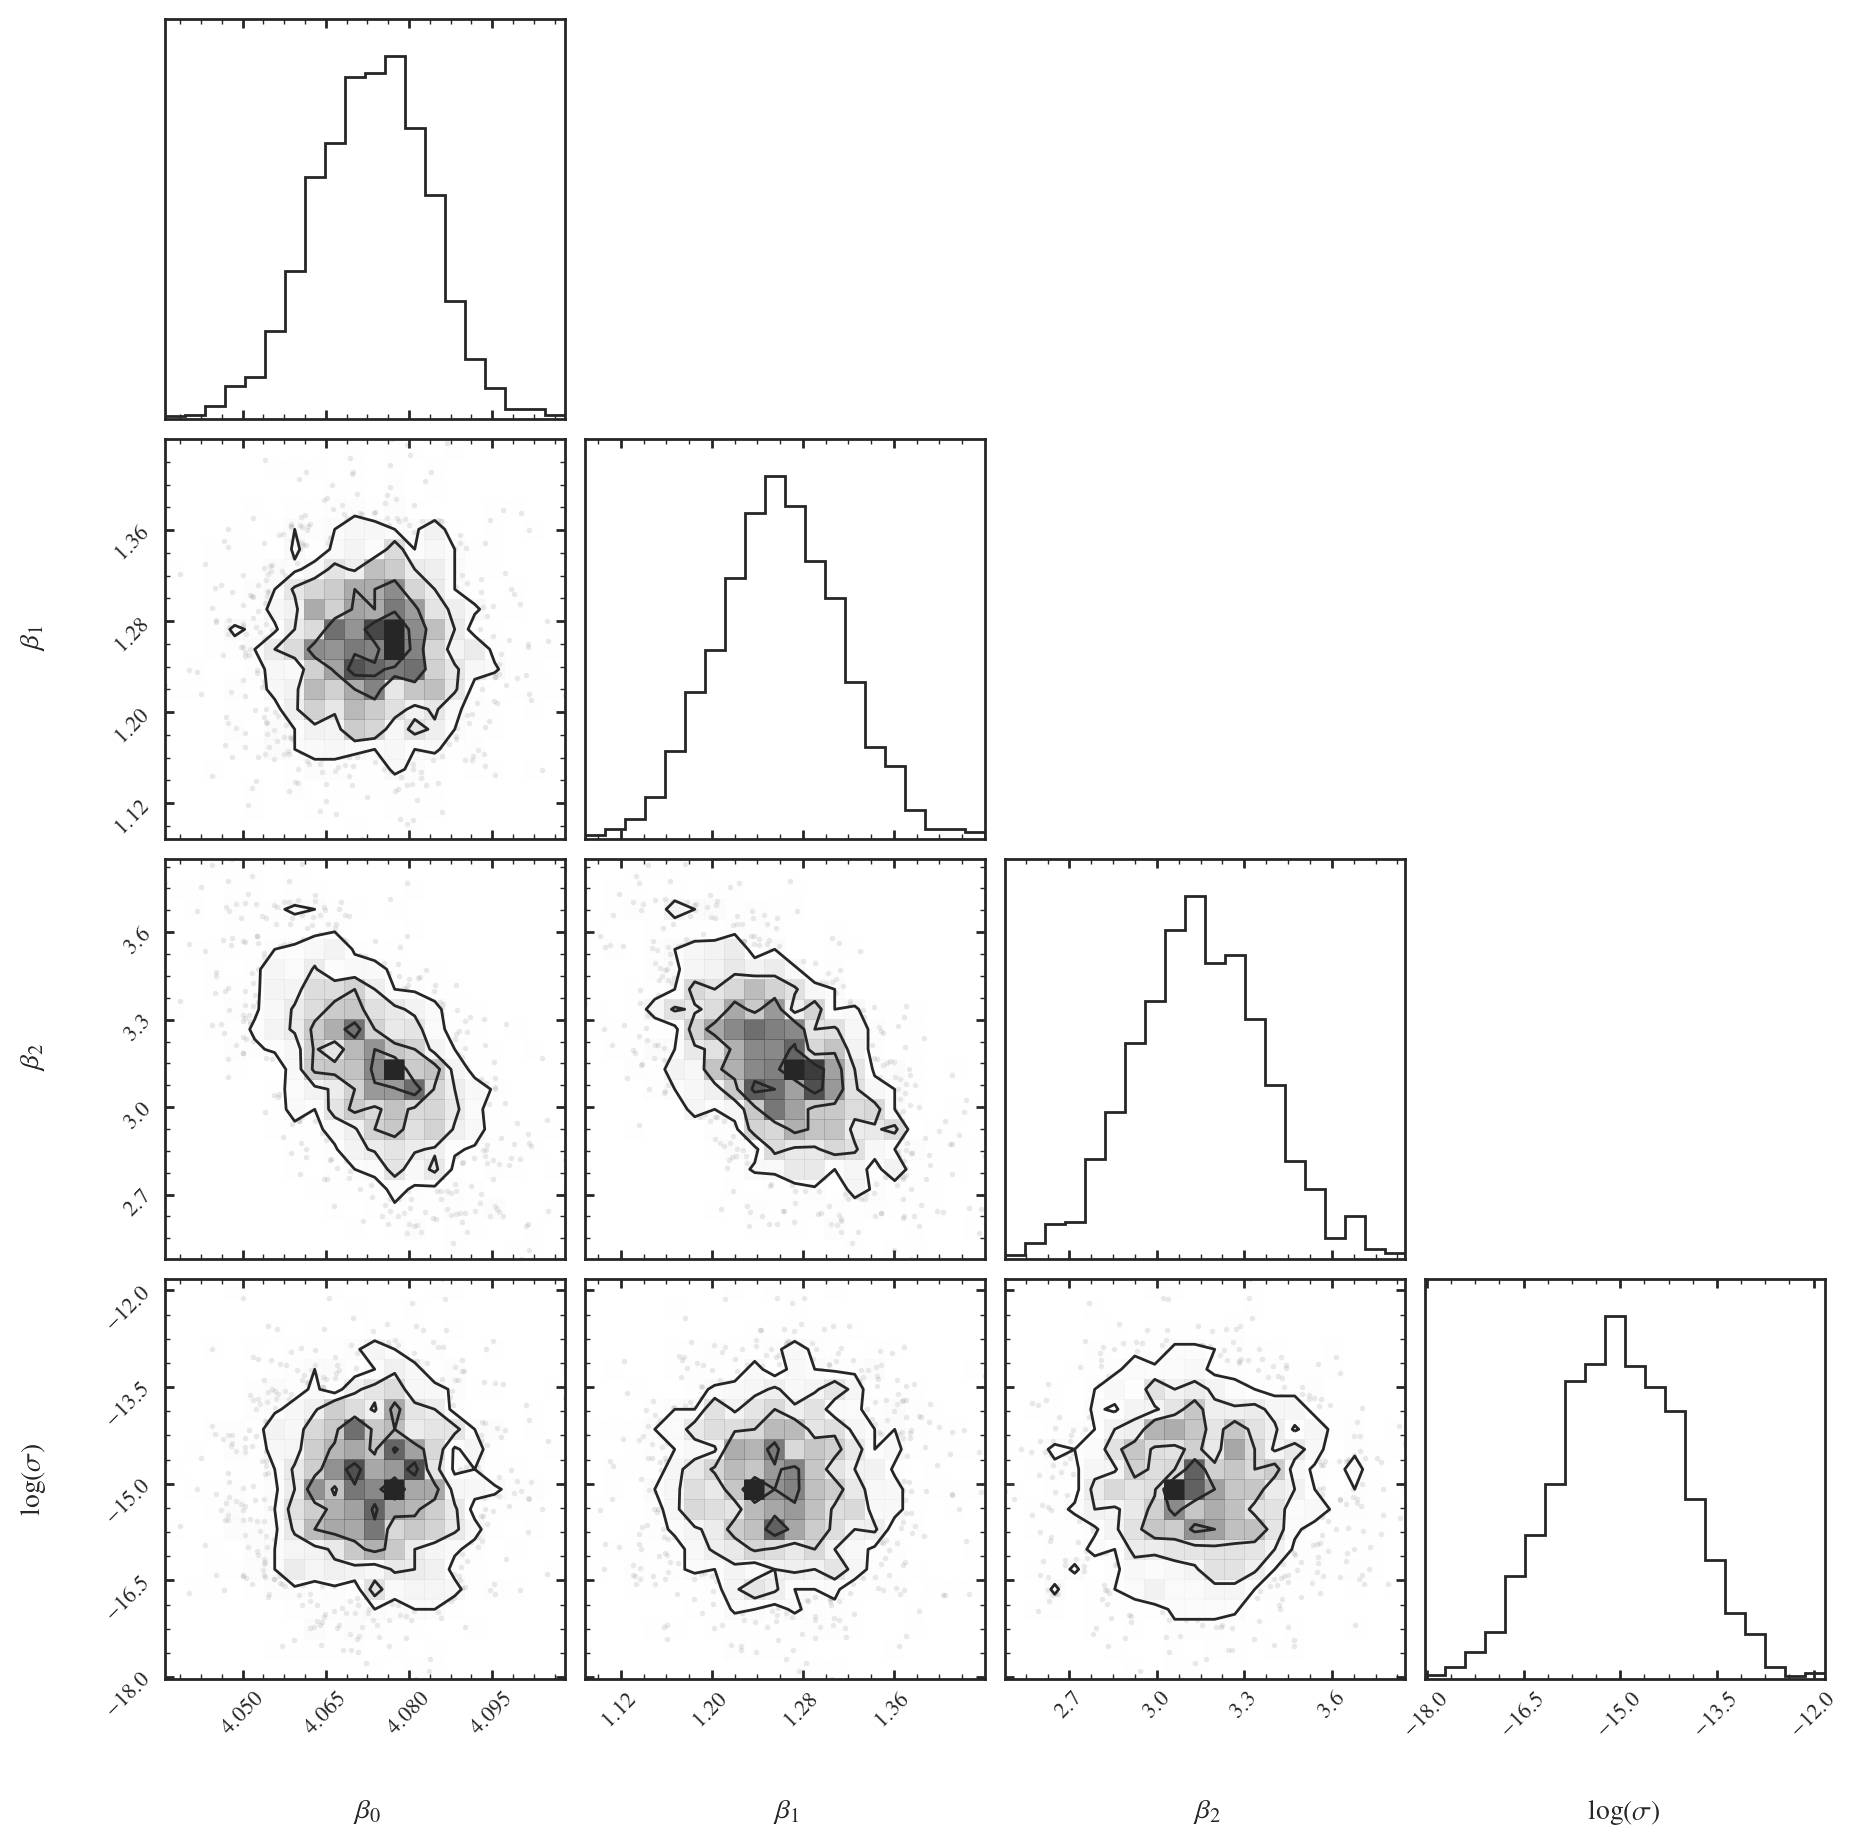

In [47]:
samples = mcmc_utils.run_mcmc(model, obs, N=N)

$\beta_0$ = 4.07e+00 + 1.11e-02 - 9.79e-03
$\beta_1$ = 1.26e+00 + 5.47e-02 - 5.25e-02
$\beta_2$ = 3.15e+00 + 2.18e-01 - 2.21e-01
$\log(\sigma)$ = -1.50e+01 + 9.86e-01 - 9.76e-01


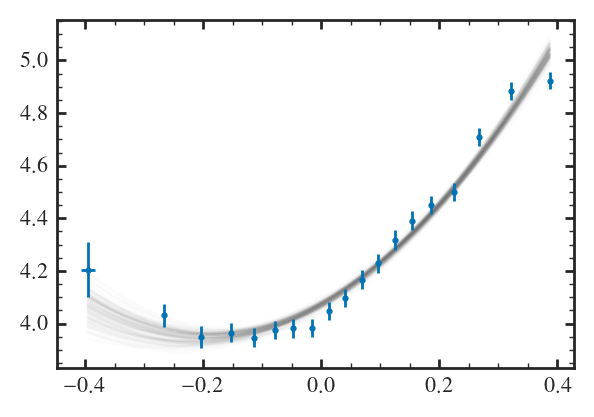

In [48]:
mcmc_utils.plot_posterior(model, obs, samples)